In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)

In [98]:
train=pd.read_csv("./input/train_u6lujuX_CVtuZ9i.csv")
test=pd.read_csv("./input/test_Y3wMUE5_7gLdaTN.csv")
train.head()
#train.tail()
#train.describe()
#train.shape
#test.shape

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
train.drop_duplicates()
#train.shape
train.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


In [48]:
# count unique values of columns

for f in train.columns:
    df = len(train[f].unique())
    if df < 12 : 
        print('Column1 <' + str(f) + '> contains <'+ str(train[f].unique())+'> unique values')
    else :
        print('Column <' + str(f) + '> contains <'+ str(df)  +'> unique values')


Column <Loan_ID> contains <614> unique values
Column1 <Gender> contains <['Male' 'Female' nan]> unique values
Column1 <Married> contains <['No' 'Yes' nan]> unique values
Column1 <Dependents> contains <['0' '1' '2' '3+' nan]> unique values
Column1 <Education> contains <['Graduate' 'Not Graduate']> unique values
Column1 <Self_Employed> contains <['No' 'Yes' nan]> unique values
Column <ApplicantIncome> contains <505> unique values
Column <CoapplicantIncome> contains <287> unique values
Column <LoanAmount> contains <204> unique values
Column1 <Loan_Amount_Term> contains <[360. 120. 240.  nan 180.  60. 300. 480.  36.  84.  12.]> unique values
Column1 <Credit_History> contains <[ 1.  0. nan]> unique values
Column1 <Property_Area> contains <['Urban' 'Rural' 'Semiurban']> unique values
Column1 <Loan_Status> contains <['Y' 'N']> unique values


     Loan_ID  Gender  Married  Dependents  Education  Self_Employed  \
0          0       0        0           0          0              0   
1          1       0        1           1          0              0   
2          2       0        1           0          0              1   
3          3       0        1           0          1              0   
4          4       0        0           0          0              0   
5          5       0        1           2          0              1   
6          6       0        1           0          1              0   
7          7       0        1           3          0              0   
8          8       0        1           2          0              0   
9          9       0        1           1          0              0   
10        10       0        1           2          0              0   
11        11       0        1           2          0             -1   
12        12       0        1           2          0              0   
13    

In [ ]:
# DOUBTS
# is credit_history category or bindary or interval variable?
# is gender, married etc. are careorical or binary variable?
# is dependents is a oridnal varialble or categorical variable
# is loan status is binary or categorical variable?

In [109]:
data = []
for f in train.columns:
    # Defining the role
    if f == 'Loan_Status':
        role = 'target'
    elif f == 'Loan_ID':
        role = 'id'
    else:
        role = 'input'
         
    # Defining the level
    if f == 'Gender' or f == 'Married' or f == 'Education' or f == 'Self_Employed' or f == 'Property_Area' or f == 'Loan_ID' or f == 'Dependents':
        level = 'nominal' 
    elif f == 'Loan_Status' :
        level = 'binary'
    elif train[f].dtype == 'float64':
        level = 'interval'
    elif train[f].dtype == 'int64':
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    if f == 'Loan_ID':
        keep = False
    
    # Defining the data type 
    dtype = train[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)
meta

,role,level,keep,dtype
varname,,,,
Loan_ID,id,nominal,False,object
Gender,input,nominal,True,object
Married,input,nominal,True,object
Dependents,input,nominal,True,object
Education,input,nominal,True,object
Self_Employed,input,nominal,True,object
ApplicantIncome,input,ordinal,True,int64
CoapplicantIncome,input,interval,True,float64
LoanAmount,input,interval,True,float64


In [104]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()
# scaling need to be applied for interval variables


,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,592.000000,600.00000,564.000000
mean,1621.245798,146.412162,342.00000,0.842199
std,2926.248369,85.587325,65.12041,0.364878
min,0.000000,9.000000,12.00000,0.000000
25%,0.000000,100.000000,360.00000,1.000000
50%,1188.500000,128.000000,360.00000,1.000000
75%,2297.250000,168.000000,360.00000,1.000000
max,41667.000000,700.000000,480.00000,1.000000


In [53]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,Dependents
count,599
unique,4
top,0
freq,345


In [100]:
train['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [101]:
vars_with_missing = []

for f in train.columns:
    missings = sum(pd.isnull(train[f]))
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

# DOUBTS
# how to handle missing values for gender,married,dependents,self employed,credithistory variables?

Variable Gender has 13 records (2.12%) with missing values
Variable Married has 3 records (0.49%) with missing values
Variable Dependents has 15 records (2.44%) with missing values
Variable Self_Employed has 32 records (5.21%) with missing values
Variable LoanAmount has 22 records (3.58%) with missing values
Variable Loan_Amount_Term has 14 records (2.28%) with missing values
Variable Credit_History has 50 records (8.14%) with missing values
In total, there are 7 variables with missing values


In [69]:
'''- **ps_car_03_cat and ps_car_05_cat** have a large proportion of  records with missing values. Remove these variables.
- For the other categorical variables with missing values, we can leave the missing value -1 as such.
- **ps_reg_03** (continuous/interval) has missing values for 18% of all records. Replace by the mean.
- **ps_car_11** (ordinal) has only 5 records with misisng values. Replace by the mode.
- **ps_car_12** (continuous) has only 1 records with missing value. Replace by the mean.
- **ps_car_14** (continuous) has missing values for 7% of all records. Replace by the mean.'''

'- **ps_car_03_cat and ps_car_05_cat** have a large proportion of  records with missing values. Remove these variables.\n- For the other categorical variables with missing values, we can leave the missing value -1 as such.\n- **ps_reg_03** (continuous) has missing values for 18% of all records. Replace by the mean.\n- **ps_car_11** (ordinal) has only 5 records with misisng values. Replace by the mode.\n- **ps_car_12** (continuous) has only 1 records with missing value. Replace by the mean.\n- **ps_car_14** (continuous) has missing values for 7% of all records. Replace by the mean.'

In [ ]:
# Imputing with the mean or mode
mean_imp = Imputer(missing_values=-1, strategy='mean', axis=0)
mode_imp = Imputer(missing_values=-1, strategy='most_frequent', axis=0)
#train['LoanAmount'] = mean_imp.fit_transform(train[['LoanAmount']]).ravel()
#train['Loan_Amount_Term'] = mean_imp.fit_transform(train[['Loan_Amount_Term']]).ravel()



In [76]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable Gender has 2 distinct values
Variable Married has 2 distinct values
Variable Dependents has 4 distinct values
Variable Education has 2 distinct values
Variable Self_Employed has 2 distinct values
Variable Property_Area has 3 distinct values


In [102]:
#factorize nominal variables
#v = meta[(meta.level == 'nominal') & (meta.keep)].index

#for f in v:
    #print(pd.factorize(train[f]))
f='Loan_Status'
train[[f]] = train[[f]].apply(lambda x: pd.factorize(x)[0])



,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,1
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,0


In [110]:
train.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,1
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,0


<Figure size 432x288 with 0 Axes>

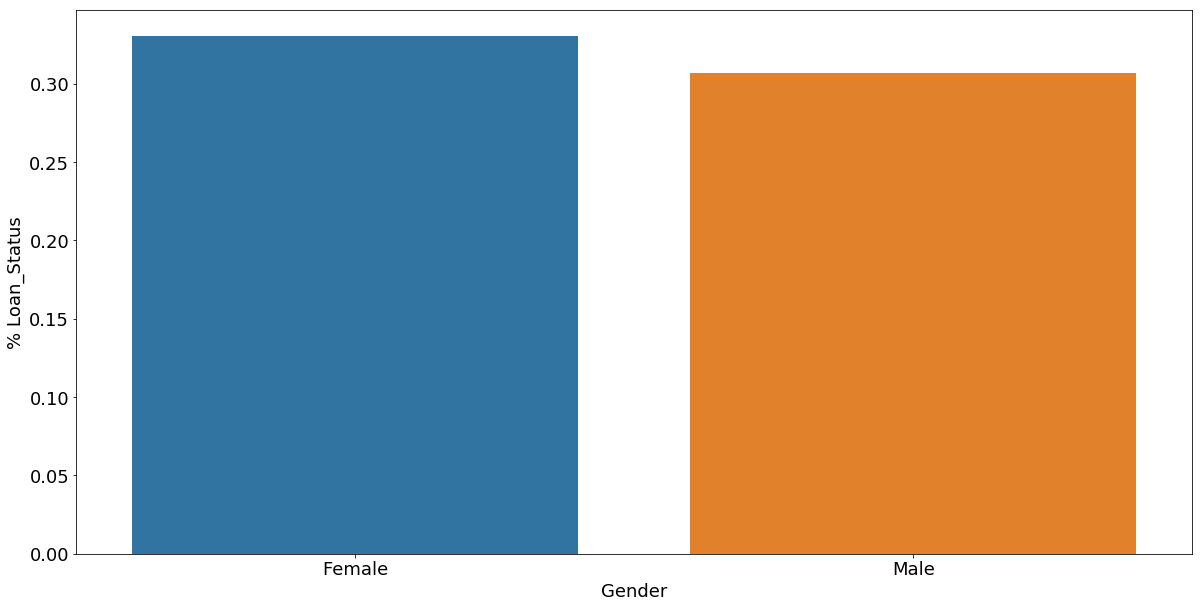

<Figure size 432x288 with 0 Axes>

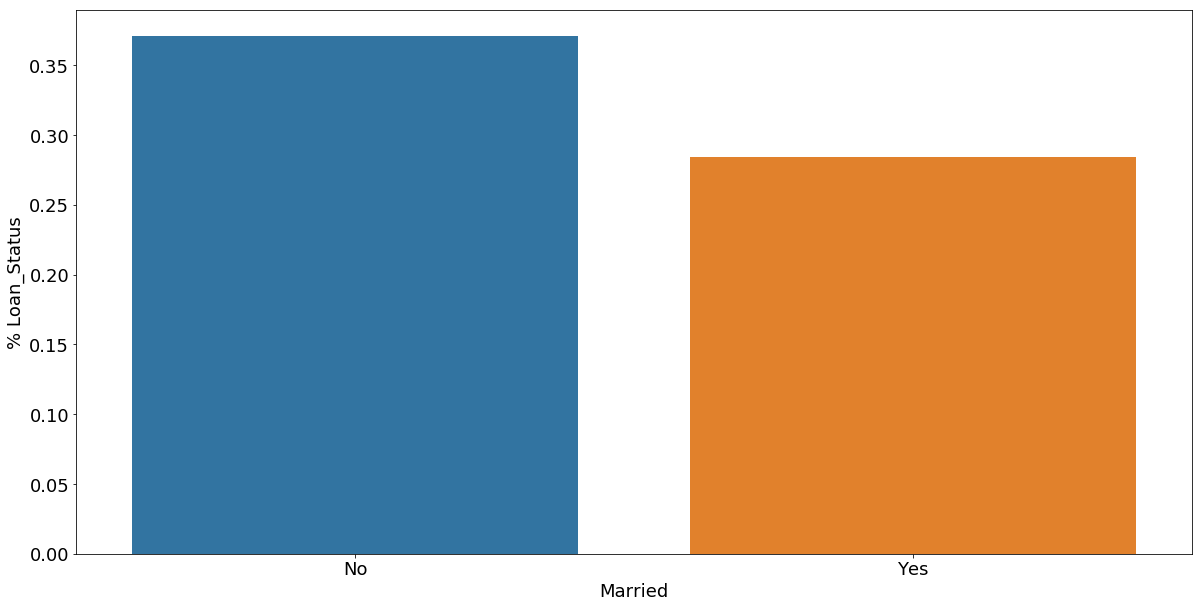

<Figure size 432x288 with 0 Axes>

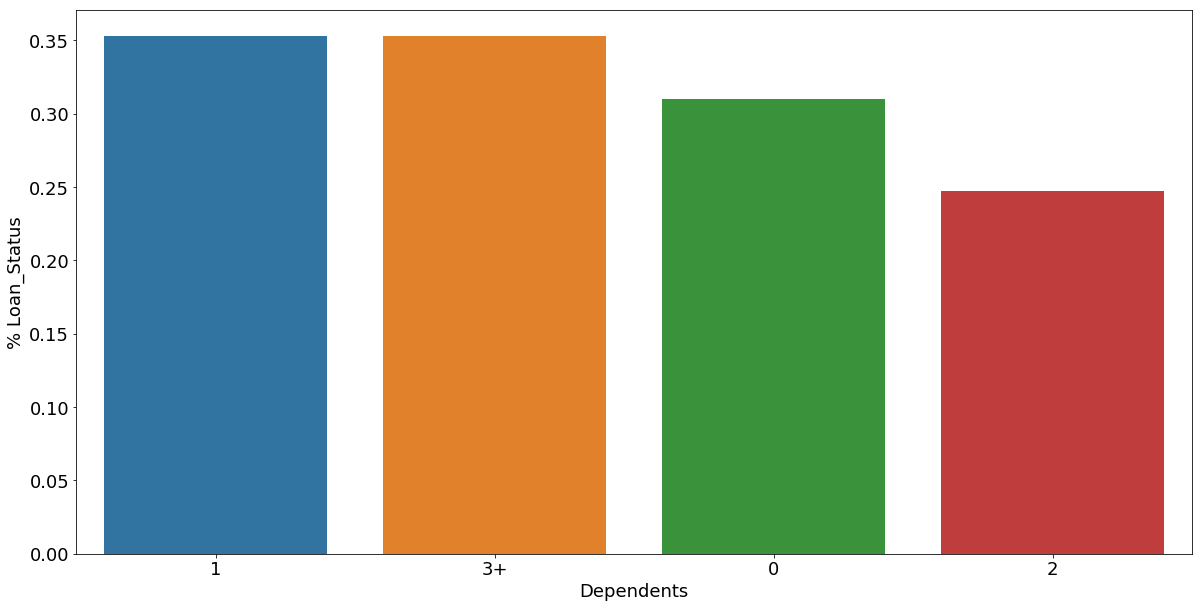

<Figure size 432x288 with 0 Axes>

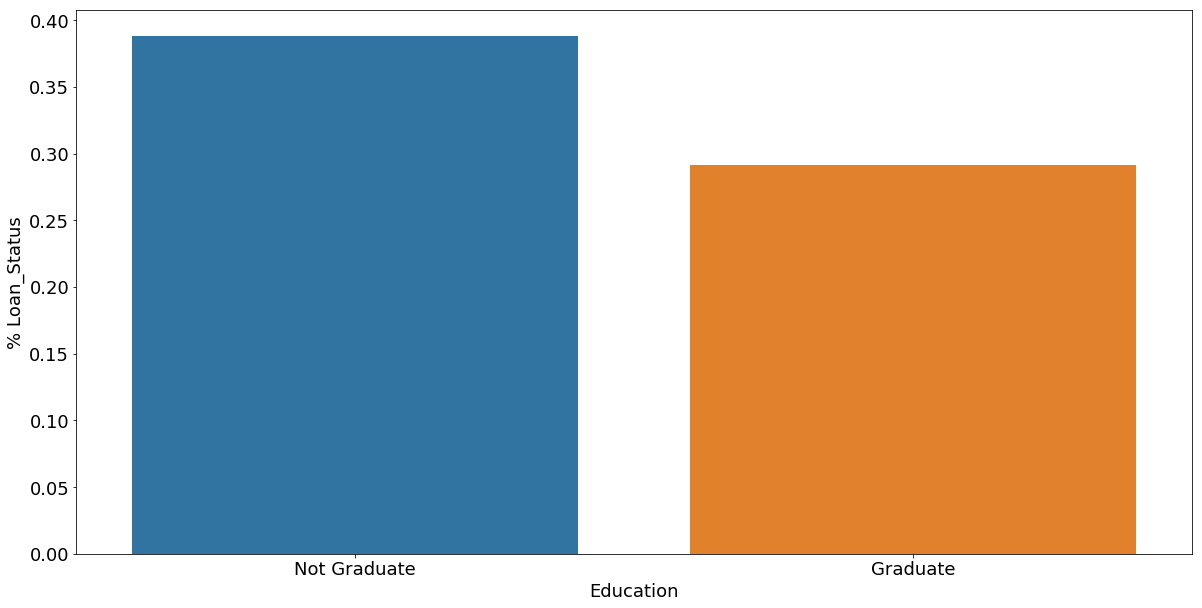

<Figure size 432x288 with 0 Axes>

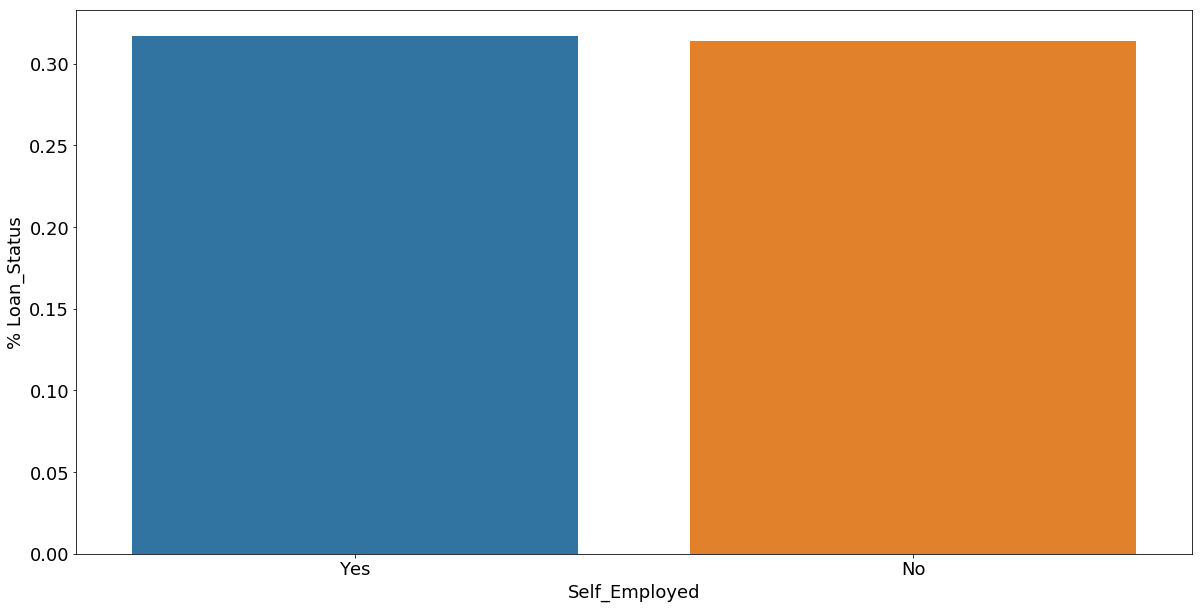

<Figure size 432x288 with 0 Axes>

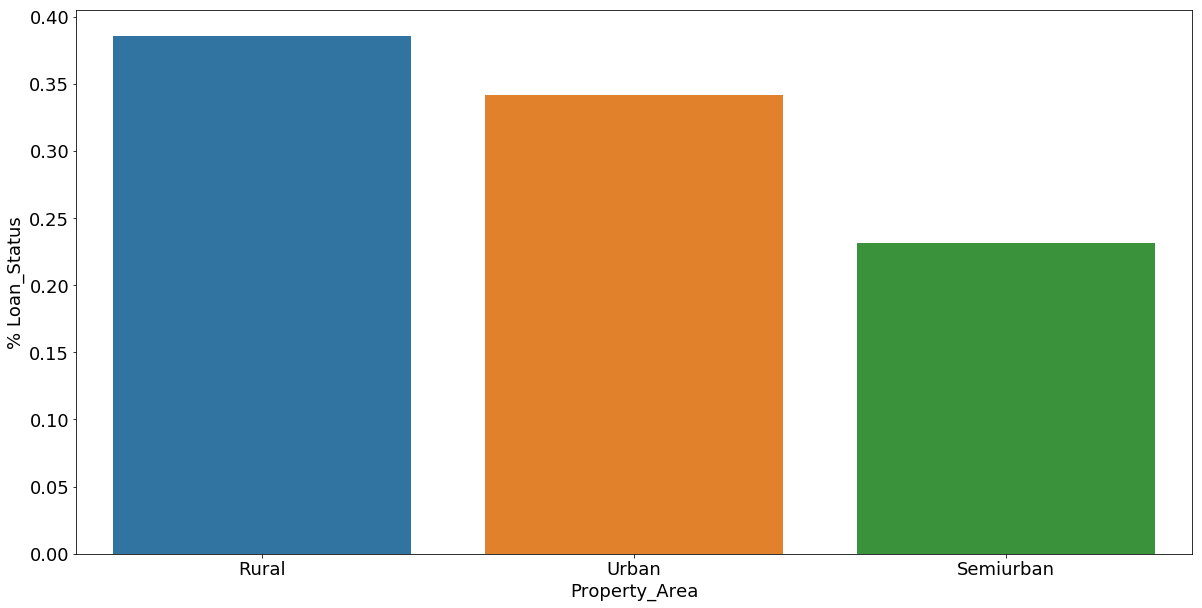

In [103]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[f, 'Loan_Status']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='Loan_Status', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='Loan_Status', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% Loan_Status', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

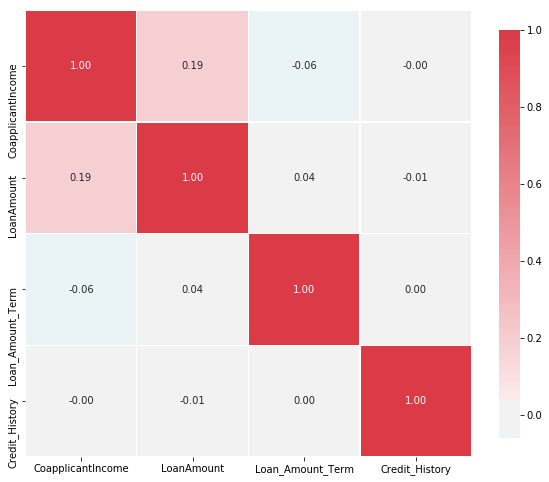

In [105]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

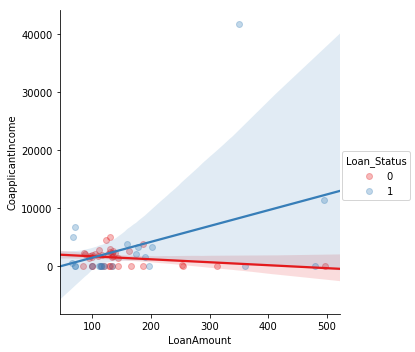

In [107]:
s = train.sample(frac=0.1)
sns.lmplot(x='LoanAmount', y='CoapplicantIncome', data=s, hue='Loan_Status', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

In [111]:
#Creating dummy variables
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))
train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

Before dummification we have 13 variables in train
After dummification we have 16 variables in train


In [115]:
#Creating intraction variables
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True)  # Remove the original columns
# Concat the interaction variables to the train data
print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [114]:
train.head()


,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,5849,0.0,NaN,360.0,1.0,0,1,0,0,0,0,0,0,0,1
1,LP001003,4583,1508.0,128.0,360.0,1.0,1,1,1,1,0,0,0,0,0,0
2,LP001005,3000,0.0,66.0,360.0,1.0,0,1,1,0,0,0,0,1,0,1
3,LP001006,2583,2358.0,120.0,360.0,1.0,0,1,1,0,0,0,1,0,0,1
4,LP001008,6000,0.0,141.0,360.0,1.0,0,1,0,0,0,0,0,0,0,1
